In [3]:
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
import sklearn
import mglearn
from IPython.display import display
import matplotlib.pyplot as plt

# 2.3.8 커널 서포트 벡터 머신

앞서 사용한 선형 서포트 벡터 머신을 단순한 초평면으로 정의되지 않는 더 복잡한 모델을 만들 수 있도록 확장한 것이다.
분류와 회귀 모두 사용 가능하지만 분류 문제만을 다룰 것이다.

## 선형 모델과 비선형 특성

직선과 초평면은 유연하지 못해 저차원 데이터셋에서의 한계가 있기에,
특성끼리 곱하거나 특성을 거듭제곱하는 식으로 새로운 특성을 추가해서 선형 모델을 유연하게 만들어야 한다.


Text(0, 0.5, 'Feature 1')

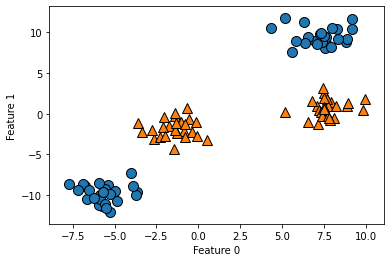

In [7]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Text(0, 0.5, 'Feature 1')

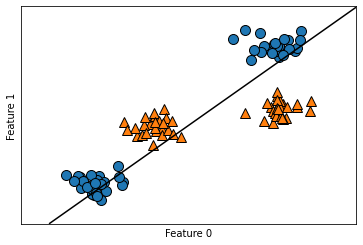

In [12]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

**선형 SVC 모델은 직선으로만 데이터 포인트를 나눌 수 있어 이런 데이터셋에는 불리하다**

**두 번째 특성을 제곱한걸 새로운 특성으로 추가->확장하여 선형 모델을 적용 시켜 볼 것이다.**

Text(0.5, 0, 'feature1')

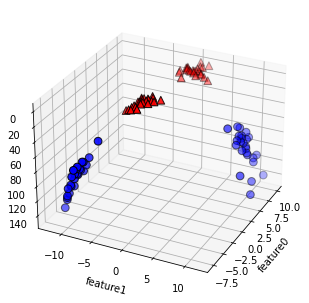

In [15]:
#두 번째 특성을 제곱하여 추가
X_new = np.hstack([X, X[:, 1:] ** 2])  #배열을 옆으로 붙이기


from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)
# y==0인 포인트를 먼저 그리고 그 다음 y==1인 포인트를 그립니다.
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Text(0.5, 0, 'feature1 ** 2')

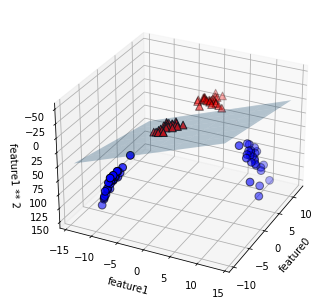

In [16]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

위와 같이 3차원 공간에서의 평면을 사용해 두 클래스를 구분했음.

원래의 특성에 투영하면 더이상 선형이 아닌 비선형 모델이 된 것을 확인할 수 있다.

Text(0, 0.5, 'Feature 1')

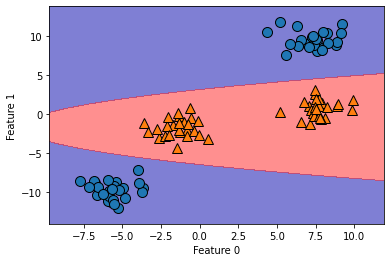

In [17]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## 커널 기법

앞에서는 선형 모델을 강력하게 만들기 위해 비선형 특성을 추가했다.
특성 추가를 많이 하다보면 연산 비용이 커지는데 수학적 기교를 사용해서 새로운 특성을 많이 만들지 않고서도 고차원에서 분류기를 학습시킬 수 있다.이를 '커널 기법'이라 하며 확장된 특성에 대한 데이터 포인트들의 거리를 계산한다.

SVC에서 데이터를 고차원 공간에 매핑하는 방법 중 많이 사용되는 방법은 다항식 커널(지정된 차수까지 고려)과 가우시안 커널(RBF, 모든 차수 고려)이 있다. 다음 절은 RBF커널을 이용하는 SVC를 설명하겠다.

## SVM 이해하기

일반적으로 훈련 데이터의 일부만 결정 경계를 만드는데 영향을 주는데 그 데이터의 일부는 보통 두 클래스 사이의 경계에 위치한 데이터 포인트들이다. 이 데이터 포인터들을 SupportVector라 하며 여기서 SVM의 이름이 유래했다.
+a -> 책 139pg 그래프 부분 

아래 그림을 보면 결정 경계는 검은 실선으로, 서포트 벡터는 굵은 테두리로 그렸다.
아래 SVM은 부드러운 비선형 경계를 만들었다.

Text(0, 0.5, 'Feature 1')

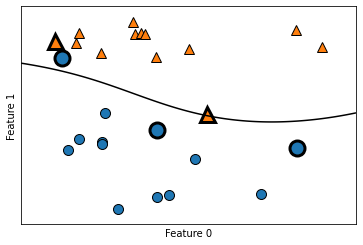

In [19]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
#데이터 포인트 그리기
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# 서포트 벡터
sv = svm.support_vectors_
# dual_coef_의 부호에 의해 서포트 벡터의 클래스 레이블이 결정된다.
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## SVM 매개변수 튜닝

gamma:앞절의 공식에 나오며 가우시안 커널 폭의 역수,훈련 샘플 하나가 미치는 영향의 범위 설정

C: 규제 매개 변수, 각 포인트의 중요도(dual_coef_)를 제한한다.

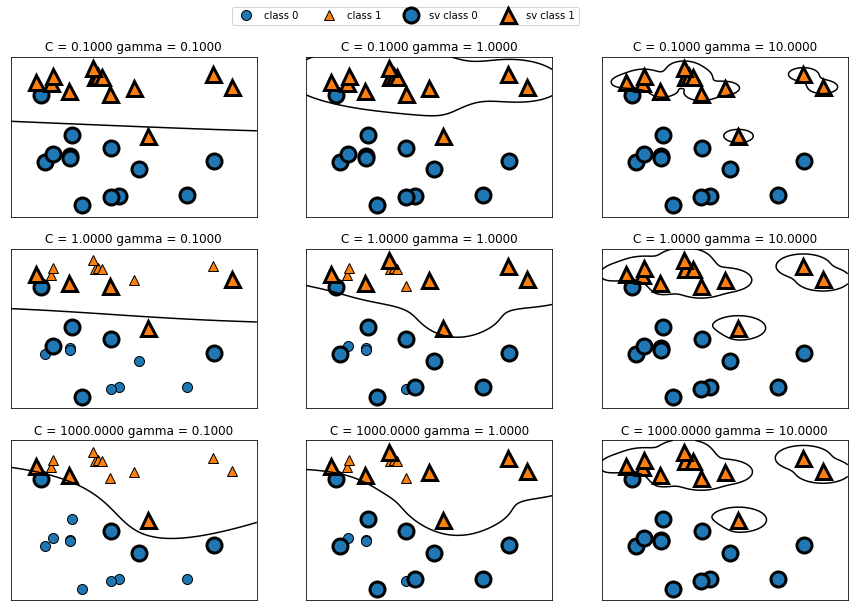

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2))

왼쪽에서 오른쪽으로 가면서 gamma가 커지는데 앞서 설명 했듯 커지면 하나의 훈련 샘플이 영향을 미칠 수 있는 범위가 작아진다. 그래서 결정 경계도 점점 하나의 포인터에 대해 민감해지며 결국 모델의 복잡도가 커진다.

C가 작으면 제약이 커서 각 데이터 포인터의 영향력이 작아지기에 거의 선형과 가까우며 잘못된 분류 데이터의 영향도 작다. 반면 C가 커감에 따라 제약이 약해지며 데이터 포인터의 영향력이 커져 결정 경계를 휘어서 정확하게 분류한다.

In [23]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.90
Accuracy on test set: 0.94


**SVM은 매개변수 설정과 데이터 스케일에 민감하다.**

책에서는 모델이 과대적합 되어서 

아래와 같이 데이터셋의 분포도를 로그 스케일로 최솟값 최댓값을 살펴보고

데이터 전처리의 필요성을 언급하며 다음 절로 넘어간다.

Text(0, 0.5, 'Feature magnitude')

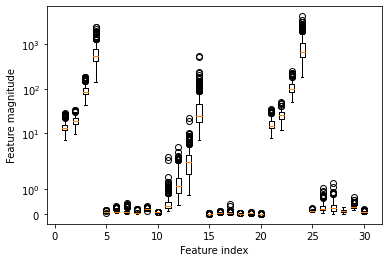

In [24]:
plt.boxplot(X_train, manage_ticks=False)
plt.yscale("symlog")
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")

## SVM을 위한 데이터 전처리

- 보통 모든 특성 값을 (평균 0, 단위 분산) or (0~1사이로 맞추기)를 많이 사용한다. 물론 데이터셋마다 다르다.

아래애선 0~1 사이로 맞추는 방법을 사용할 것이다.

In [25]:
# 훈련 세트에서 특성별 최솟값 계산
min_on_training = X_train.min(axis=0)
# 훈련 세트에서 특성별(최댓값 - 최솟값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)

# 훈련 데이터에 최솟값을 빼고 범위로 나누면
# 각 특성은 0~1 사이의 값으로 변환된다.
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n", X_train_scaled.min(axis=0))
print("Maximum for each feature\n", X_train_scaled.max(axis=0))

Minimum for each feature
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [28]:
# 테스트 세트에도 같은 작업을 적용하지만
# 훈련 세트와 검증 세트를 각각 다른 비율(각자의 최솟값과 최댓값)로 전처리를 해주면
# 훈련 세트에 적용된 알고리즘이 테스트 세트의 샘플 데이터를 잘못 인식하기에
# 훈련 세트에서 사용한 최솟값과 범위를 사용한다.(딥러닝 128pg)
X_test_scaled = (X_test - min_on_training) / range_on_training

In [29]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
        svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.984
Accuracy on test set: 0.972


**위의 결과가 과소적합이라 C or gamma 값을 증가시켜 복잡도를 높인다고 C를 증가시켰지만 아래를 보면 이 컴퓨터 환경에선 과대적합이 일어났다.**

In [30]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))


Accuracy on training set: 1.000
Accuracy on test set: 0.958


## 장단점과 매개변수

> 장점

   - **보통 10만개 이상의 데이터셋을 제외하곤 다양한 데이터셋에서 강력하게 잘 작동함.**

> 단점

   - **데이터 전처리, 매개변수 설정에 민감하고 모델을 분석하기도 힘듦. -> 전처리가 거의 필요없는 트리기반 모델을 사용하게 됨,**
   
   
> 매개변수

   - **규제 매개변수인 C가 주요하며 RBF 커널은 가우시안 커널 폭의 역수인 gamma 매개변수를 하나 가짐. 서로 연관성이 크며 둘 다 큰 값이 더 복잡한 모델을 만듬.**


# 2.3.9 신경망(딥러닝)

 - **신경망이라고 알려진 알고리즘들은 '딥러닝'이라고 주목받고 있으며 특정 분야에 정교하게 적용되어 있을 때가 많다. 복잡한 딥러닝 알고리즘의 출발점이며 비교적 간단하게 분류와 회귀에 쓸 수 있는 다층 퍼셉트론(MultiLayerPerceptrons)을 다루겠다.**
 
## 신경망 모델

MLP는 여러 단계를 거쳐 결정을 만들어내는 선형 모델의 일반화된 모습이라고 볼 수 있다.

예측 공식: y^ = w[0]*X[0]+ w[1]*X[1] + ... + w[p]*X[p] + b

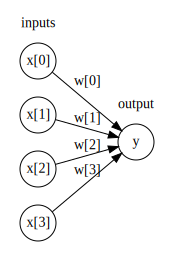

In [34]:
display(mglearn.plots.plot_logistic_regression_graph())
#왼쪽 노드는 입력 특성을, 연결선은 학습된 계수, 오른쪽 노드는 입력의 가중치 합(출력)

**MLP에서는 출력(가중치 합)을 만드는 과정이 여러 번 반복되며 중간 단계를 구성하는 HiddenUnit(은닉 유닛)을 계산하고 최종 결과를 산출하기 위해 다시 가중치 합을 계산한다**

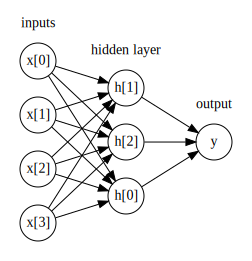

In [33]:
display(mglearn.plots.plot_single_hidden_layer_graph())

여러 개의 가중치 합을 계산하는 것은 수학적으로 보면 하나의 가중치 합을 계산하는 것과 같다. 그래서 선형 모델보다 강력하게 만들기 위해 다른 기교들이 필요하다.

각 은닉 유닛의 출력(가중치 합)을 비선형 함수인 '렐루'나 '하이퍼 볼릭 탄젠트'를 적용한다. 이 함수 결과의 가중치 합을 계산하여 출력 y^을 만든다.

아래는 두 함수를 나타낸 것으로 렐루 함수는 0이하를 잘라버리고, tanh 함수는 낮은 입력값에 대해서는 -1로 수렴하고 큰 입력값에 대해서는 +1로 수렴한다. 이런 방식을 통해 선형 모델보다 더 복잡한 함수를 학습할 수 있다. 차별점을 두는 것이다.

Text(0, 0.5, 'relu(x), tanh(x)')

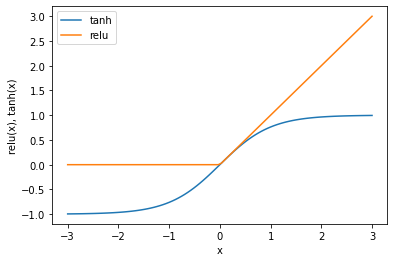

In [35]:
line = np.linspace(-3, 3, 100)
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), label="relu")
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("relu(x), tanh(x)")

### 시그모이드 함수인가?

작은 신경망으로 회귀 분석을 하는 수학 식은 밑의 구성도를 식으로 표현할 것일 뿐이니 따로 적진 않겠다. 또한 딥러닝에선 은닉층의 유닛 개수가 중요한 매개변수이며 아래와 같이 은닉층을 추가할 수 있고, 더 나아가 많은 은닉층으로 구성된 대규모의 신경망이 생기면서 이를 딥러닝이라고 부른다.

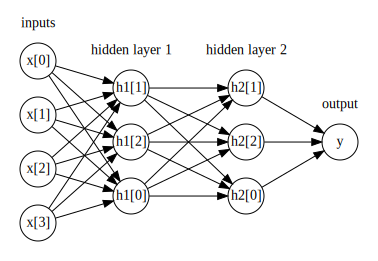

In [36]:
mglearn.plots.plot_two_hidden_layer_graph()

## 신경망 튜닝

- 아래는 'two_moons' 데이터셋에 분류를 위한 MLP구현인 MLPClassifier 적용

Text(0, 0.5, 'Feature 1')

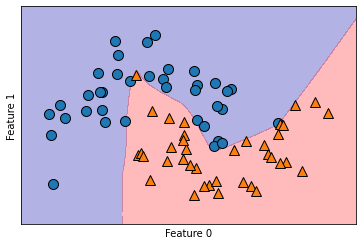

In [41]:
# 1개의 은닉층, 100개의 유닛
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

**MLP는 기본적으로 은닉 유닛이 100개인데 작은 데이터셋에선 과분하여 10개로 줄여도 된다.은닉층이 1개 은닉 유닛이 10개라 10개의 직선이 합쳐져서 구성되어 날카로운 경계를 가진다**

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Text(0, 0.5, 'Feature 1')

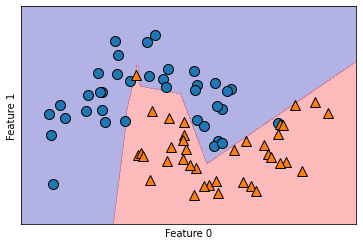

In [40]:
# 1개의 은닉층, 10개의 유닛
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10])
mlp.fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

더 매끄러운 결정 경계를 갖고 싶다면 은닉 유닛, 은닉층을 늘리거나 비선형 함수를 tanh 함수로 변경해주면 된다.

Text(0, 0.5, 'Feature 1')

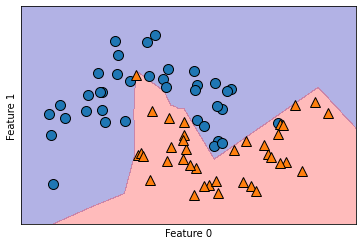

In [39]:
# 2개의 은닉층, 10개의 유닛
mlp = MLPClassifier(solver='lbfgs', random_state=0,
                    hidden_layer_sizes=[10, 10])
mlp.fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Text(0, 0.5, 'Feature 1')

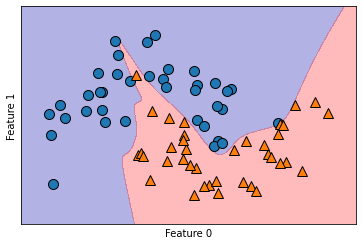

In [42]:
# 2개의 은닉층, 10개의 유닛, tanh 함수
mlp = MLPClassifier(solver='lbfgs', activation='tanh',
                    random_state=0, hidden_layer_sizes=[10, 10])
mlp.fit(X_train, y_train)
mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

밑은 alpha 값에 따라 변하는 결정 경계이다.

선형 회귀 모델과 같이 alpha 값이 커지면 제약이 커지며 그에따라 복잡도는 줄어든다.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


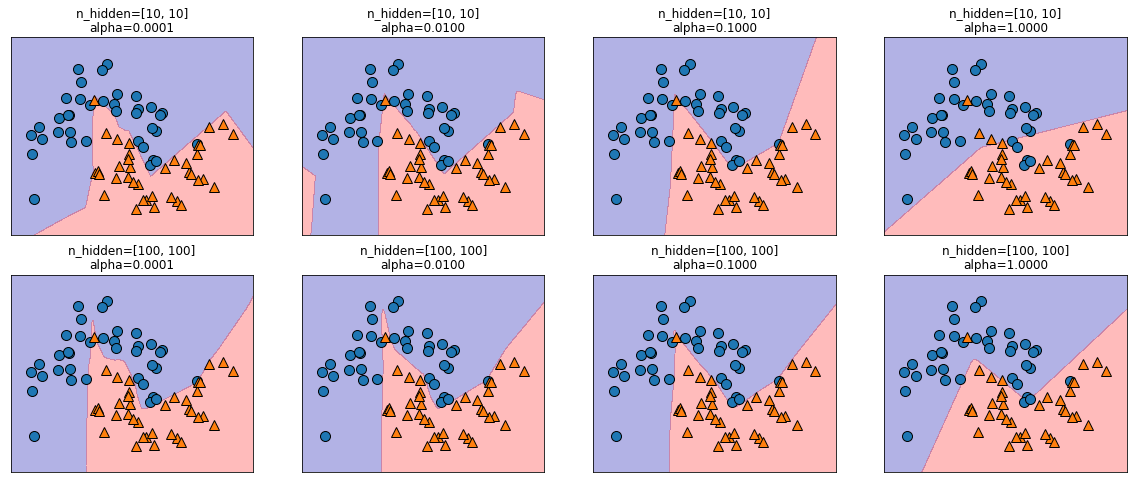

In [43]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for axx, n_hidden_nodes in zip(axes, [10, 100]):
    for ax, alpha in zip(axx, [0.0001, 0.01, 0.1, 1]):
        mlp = MLPClassifier(solver='lbfgs', random_state=0,
                            hidden_layer_sizes=[n_hidden_nodes, n_hidden_nodes],
                            alpha=alpha)
        mlp.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
        mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
        ax.set_title("n_hidden=[{}, {}]\nalpha={:.4f}".format(
                      n_hidden_nodes, n_hidden_nodes, alpha))

신경망이 작을 경우엔 같은 매개변수를 사용하더라도 초깃값에 따라 모델이 달라진다.

크고 복잡한 신경망일 경우엔 초깃값의 영향이 크진 않다.

아래는 초깃값에 따라 달라지는 결정 경계를 나타낸다.

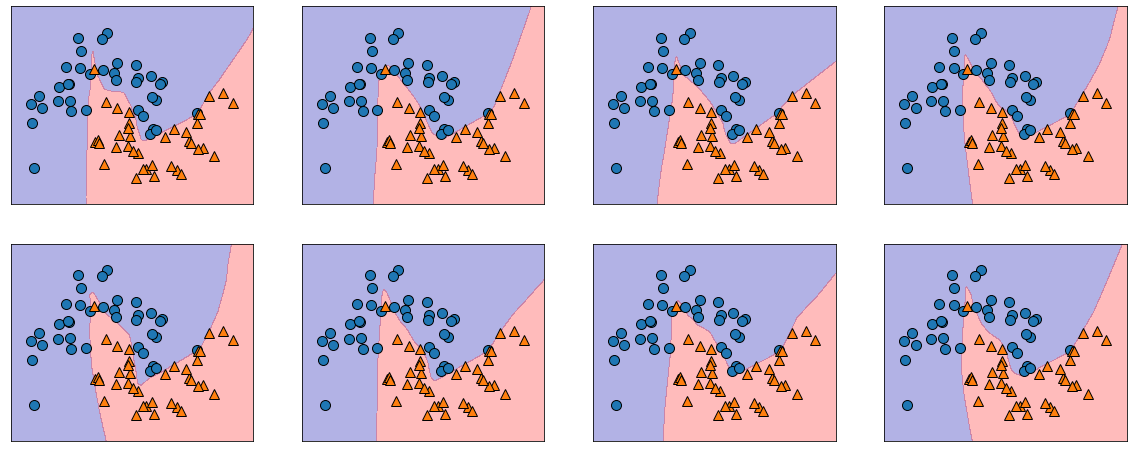

In [44]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i, ax in enumerate(axes.ravel()):
    mlp = MLPClassifier(solver='lbfgs', random_state=i,
                        hidden_layer_sizes=[100, 100])
    mlp.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)

**유방암 데이터셋에 MLPClassifier을 적용해보자**

In [45]:
print("Cancer data per-feature maxima:\n{}".format(cancer.data.max(axis=0)))

Cancer data per-feature maxima:
[2.811e+01 3.928e+01 1.885e+02 2.501e+03 1.634e-01 3.454e-01 4.268e-01
 2.012e-01 3.040e-01 9.744e-02 2.873e+00 4.885e+00 2.198e+01 5.422e+02
 3.113e-02 1.354e-01 3.960e-01 5.279e-02 7.895e-02 2.984e-02 3.604e+01
 4.954e+01 2.512e+02 4.254e+03 2.226e-01 1.058e+00 1.252e+00 2.910e-01
 6.638e-01 2.075e-01]


In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 0.94
Accuracy on test set: 0.92


In [48]:
# 훈련 세트 각 특성의 평균을 계산합니다.
mean_on_train = X_train.mean(axis=0)
# 훈련 세트 각 특성의 표준 편차를 계산합니다.
std_on_train = X_train.std(axis=0)

# 데이터에서 평균을 빼고 표준 편차로 나누면
# 평균 0, 표준 편차 1인 데이터로 변환 된다.
X_train_scaled = (X_train - mean_on_train) / std_on_train
# SVC 때 처럼 훈련 데이터와 같은 비율로 스케일링을 진행
X_test_scaled = (X_test - mean_on_train) / std_on_train

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.965


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


확률적 최적화 도구: 최대 반복 (200)에 도달했고 최적화가 아직 수렴되지 않았습니다.

위는 기본 solver인 adam 알고리즘에 관한 경고이며 이에 따라 최대 반복 횟수를 늘려준다. 'max_iter'

이정도로도 좋은 결과를 주지만 과대적합이 의심 되므로 가중치를 규제해서 복잡도를 낮춰볼 것이다.


In [49]:
mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))


Accuracy on training set: 1.000
Accuracy on test set: 0.972


alpha 매개변수의 기본값인 0.0001에서 1로 증가시켜보았다.

과대적합이 줄어든 것을 볼 수 있다.

In [50]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


신경망이 어떻게 학습하는지, 무엇이 학습됐는지 판단하긴 선형이나 트리보단 비교적 어렵다.

이때 가중치를 확인해보면 되는데 아래는 입력과 은닉층 사이의 학습된 가중치를 보여준다.

mean smoothness, mean compactness가 다른 특성들 보다 가중치가 낮은데 덜 중요하거나 신경망에 적절치 못하게 입력되었을 것으로 유추할 수 있다.

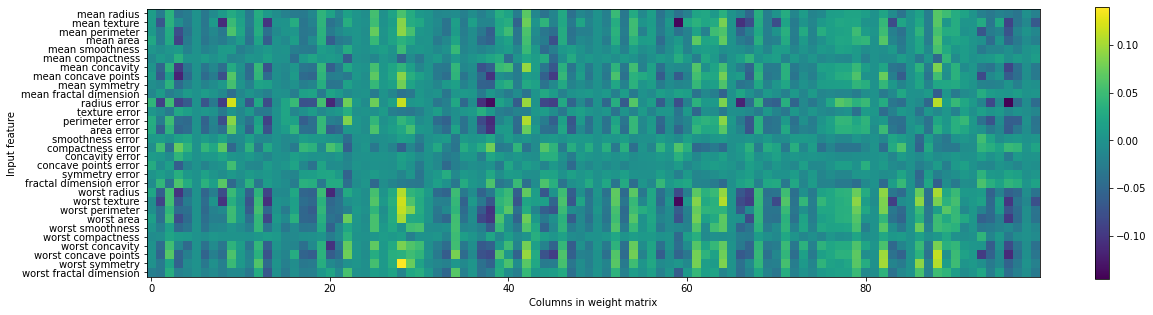

In [51]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

### 신경망의 장단점과 매개변수

대량의 데이터에 내재된 정보를 잡아내고 복잡한 모델을 만들 수 있다는점, 충분한 연산 시간과 데이터를 주고 매개변수를 잘 조절하면 다른 머신러닝 알고리즘을 뛰어넘기도 한다는게 장점이다. 

단점으로는 데이터 전처리에 주의해야 하며 학습이 오래걸린다는 점이다. 또한 동질의 데이터에서 잘 작동하나 다른 종류의 특성을 가진 데이터라면 트리 모델이 더 잘 작동할 수 있다. 게다가 매개변수 튜닝에는 위에서 다루지 않은 매우 많은 방법이 중요하다.

### 신경망의 복잡도 추정

신경망에서 가장 중요한 매개변수는 은닉층의 개수와 각 은닉층의 유닛수이다.
은닉측의 유닛 수는 보통 입력 특성의 수와 비슷하게 설정하지만 수천 초중반을 넘는 일은 거의 없다.

복잡도에 관해 도움이 될 만한 측정치는 160pg

매개변수를 조정하는 일반적인 방법은 과대적합되었고 문제를 해결할만한 큰 모델을 만든 후 훈련 데이터가 충분히 학습되겠다 싶을 때, 신경망 구조를 줄이거나 규제 강화를 하여 일반화 성능을 늘리는 것이다.

> 알고리즘 매개변수인 solver는 아래와 같다.

adam: 대부분의 경우에 잘 작동하지만 데이터 스케일에 민감함

lbfgs: 안정적이지만 규모가 큰 모델이나 대량의 데이터셋에선 시간이 오래 걸림

sgd: 많은 연구자들이 사용하며 다른 여러 매개변수화 함께 튜닝하여 최상의 결과를 이끌어낼 수 있음.


# 2.4 분류 예측의 불확실성 추정

***암의 진료할 때 거짓 음성은 심각한 상황을 초래한다. 그래서 분류기의 예측에 대한 불확실성을 추정하는 것이 필요하다. 사이킷런 분류기에서 불확실성을 추정할 수 있는 함수가 두개 있으며 decision_function과 predict_proba가 있다. 대부분의 분류기는 둘중 최소 하나를 제공하는 경우가 많다.**

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# 예제를 위해 클래스의 이름을 'blue'와 'red'로 바꾼다.
y_named = np.array(["blue", "red"])[y]

# 여러개의 배열을 한번에 나눌 수 있다.
# 훈련 세트와 테스트 세트로 나뉘는 방식은 모두 같다.
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# 그레이디언트 부스팅 모델을 만든다.
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)


GradientBoostingClassifier(random_state=0)

## 2.4.1 결정 함수

이진 분류에서 decision_function 반환값의 크기는 (n_samples,)이고 각 샘플이 하나의 실수 값을 반환한다. 양수이면 양성 클래스인 클래스 1에 속한다고 믿는 정도이며 음수일 땐 그 반대이다.

In [53]:
print("X_test.shape:", X_test.shape)
print("Decision function shape:",
      gbrt.decision_function(X_test).shape)

X_test.shape: (25, 2)
Decision function shape: (25,)


In [54]:
# 결정 함수 결과 중 앞부분 일부를 확인합니다.
print("Decision function:", gbrt.decision_function(X_test)[:6])

Decision function: [ 4.13592603 -1.70169917 -3.95106099 -3.62609552  4.28986642  3.66166081]


**위처럼 결정함수의 부호만 보고 예측 결괴를 알 수 있다. 아래에서 확인 가능**

In [55]:
print("Thresholded decision function:\n",
      gbrt.decision_function(X_test) > 0)
print("Predictions:\n", gbrt.predict(X_test))

Thresholded decision function:
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


**아래는 불리언 값을 숫자로 변환하여 저장하는 부분**

음성 클래스는 항상 classes_ 속성의 첫 번째 원소이고 두 번째 원소는 양성 클래스.
그래서 predict 함수의 결과를 완전히 재현하려면 classes_ 속성을 사용하면 된다. (여기 이해잘 안감)

In [57]:
# 불리언 값을 0과 1로 반환한다.
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# 0과 1을 classes_의 인덱스로 사용한다.
pred = gbrt.classes_[greater_zero]
# pred 와 gbrt.predict의 결과를 비교한다.
print("pred is equal to predictions:",
      np.all(pred == gbrt.predict(X_test)))

pred is equal to predictions: True


decision_function 값의 범위는 데이터와 모델 파라미터에 따라 달라지며 출력 범위는 아래와 같음

In [58]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
      np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


**다음은 2차원 평면의 모든 점에 대해 decision_function값을 색으로 표현하여 결정 경계와 함께 그래프로 나타내는 것이다. (훈련 데이터는 원 모양, 데스트 데이터는 삼각형)**

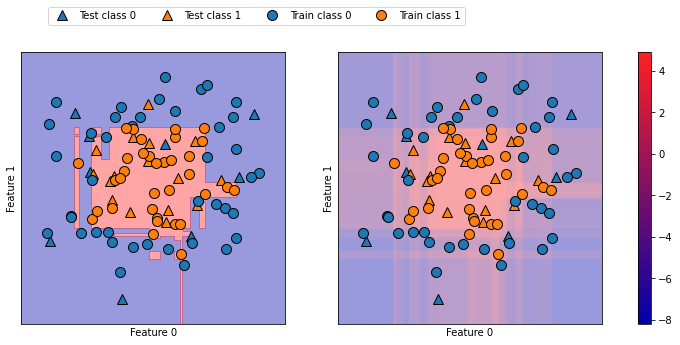

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1],
                                            alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 훈련 데이터와 테스트 포인트 그리기
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

**결정 함수 그래프에서 두 클래스 사이의 경계를 구분하기는 어렵다.**

## 2.4.2 예측 확률

predict_proba의 출력은 각 클래스에 대한 확률이고 이 값의 크기는 이진 분류에선 항상 (n_ samples,2) 이다.

In [62]:
print("Shape of probabilities:", gbrt.predict_proba(X_test).shape)

# (첫 번째 클래스의 예측 확률, 두 번째 클래스의 예측 확률 )
# 확률이라 항상 0~1 사이의 값이고 두 클래스에 대한 확률의 합은 항상 1이다.

Shape of probabilities: (25, 2)


In [63]:
# predict_proba 결과 중 앞부분 일부를 확인한다.
print("Predicted probabilities:")
print(gbrt.predict_proba(X_test[:6]))

Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575653 0.15424347]
 [0.98112869 0.01887131]
 [0.97407033 0.02592967]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


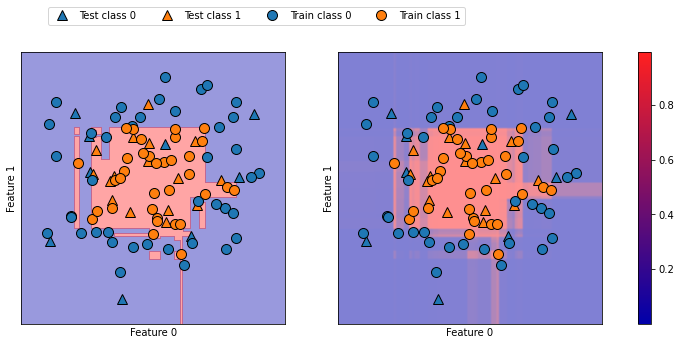

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 훈련 포인트와 테스트 포인트 그리기
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
# colorbar를 감추지 않는다.
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

**위 그래프의 경계는 훨씬 잘 나타나있고 불확실성이 있는 작은 영역들도 잘 확인할 수 있다.또한 167pg을 보면 많은 모델의 불확실성 추정이 어떤지 비교할 수 있게 옮겨져있다.**

## 2.4.3 다중 분류에서의 불확실성

위의 두 함수 모두 다중 분류에도 사용할 수 있다. 단 다중 분류에서의 결괏값 크기는 (n_samples,n_classes)이다.

다음은 iris 데이터셋에 적용하는 것이다.

### decision_function을 적용
(n_samples,n_classes)
- 각 클래스에 대한 확신 점수를 담고 있으며 수치가 크면 그 클래스일 가능성이 큼.

In [67]:
#iris 데이터셋을 불러온 후 나누고 그레디이언트 부스팅에 fit

from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [68]:
print("Decision function shape:", gbrt.decision_function(X_test).shape)
# decision function의 결과 중 앞부분 일부 확인
print("Decision function:")
print(gbrt.decision_function(X_test)[:6, :])

Decision function shape: (38, 3)
Decision function:
[[-1.995715    0.04758267 -1.92720695]
 [ 0.06146394 -1.90755736 -1.92793758]
 [-1.99058203 -1.87637861  0.09686725]
 [-1.995715    0.04758267 -1.92720695]
 [-1.99730159 -0.13469108 -1.20341483]
 [ 0.06146394 -1.90755736 -1.92793758]]


In [69]:
print("Argmax of decision function:")
print(np.argmax(gbrt.decision_function(X_test), axis=1))
print("Predictions:")
print(gbrt.predict(X_test))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


### predict_proba에 적용
(n_samples,n_classes)

 - 앞서 본 것과 같이 0~1사이의 값이며 모든 클래스에 대한 확률의 합은 1이다.

In [71]:
# predict_proba의 결과 중 앞부분 일부 확인
print("Predicted probabilities:")
print(gbrt.predict_proba(X_test)[:6])
# 행 방향으로 확률을 더하면 1, 즉 모든 클래스에 대핸 확률의 합은 1이다.
print("Sums:", gbrt.predict_proba(X_test)[:6].sum(axis=1))

Predicted probabilities:
[[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]
Sums: [1. 1. 1. 1. 1. 1.]


**함수의 결괏값에 argmax 함수를 적용하면 예측을 할 수 있음**

In [72]:
print("Argmax of predicted probabilities:")
print(np.argmax(gbrt.predict_proba(X_test), axis=1))
print("Predictions:")
print(gbrt.predict(X_test))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


**정리하면 두 함수의 결괏값은 항상 (n_samples,n_classes)인데 이진 분류에서만 특별한 것이다. 단, 주의할 것은 클래스가 문자열이거나 정수형을 사용하지만 연속적이지 않고 0부터 시작할 수 있다. 그래서 다음과 같이 classes_ 속성을 사용해 클래스의 실제 이름을 얻어야 한다.**

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
logreg = LogisticRegression()

# iris 데이터셋의 타깃을 클래스 이름으로 나타내기

named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("unique classes in training data:", logreg.classes_)
print("predictions:", logreg.predict(X_test)[:10])
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function:", argmax_dec_func[:10])
print("argmax combined with classes_:",
      logreg.classes_[argmax_dec_func][:10])

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 파트의 요약은 책에 잘 서술되어 있으니 나중에 정리하겠3